<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/3.%20Frameworks%20Software/Practica3.4.%20Keras%3A%20clasificacion%20binaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 3.4. Clasificación Binaria

La clasificación binaria es, posiblemente, el tipo de problema con mayor número de aplicaciones en ML. En esta práctica vamos a ver cómo construir un clasificador binario en PyTorch, cómo trabajar con un dataset tabular y desbalanceado, y cómo trabajar con otras métricas de calidad. Concretamente, construiremos una red neuronal que nos ayude a clasificar si un movimiento en una tarjeta de crédito es fraudulento, mediante el dataset [*Credit Card Fraud Detection*](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

Comencemos importando PyTorch y comprobando si tenemos GPU.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('PyTorch version:', torch.__version__, '\nDevice:', device)

PyTorch version: 2.3.0+cu121 
Device: cuda


## 1. Preparación del dataset

### 1.1. Descarga

A continuación puedes descargar los datos y descomprimirlo con el siguiente código. Si el enlace de descarga ha dejado de funcionar, puedes descargarlo a mano desde [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud), o bien usando Kagglehub como se indica en la web.

In [ ]:
from pathlib import Path
import requests
import zipfile

DATA_PATH = Path("./data")
PATH = DATA_PATH / "creditcard"

PATH.mkdir(parents=True, exist_ok=True)  # creamos la carpeta

URL = "https://clouda-labs-assets.s3-us-west-2.amazonaws.com/fraud-detection/"
FILENAME = "creditcard.csv.zip"

if not (PATH / FILENAME).exists(): # evitamos descargar si ya se ha descargado
        content = requests.get(URL + FILENAME).content  # descargamos el fichero
        (PATH / FILENAME).open("wb").write(content)

        with zipfile.ZipFile((PATH / FILENAME), 'r') as zip_ref: # descomprimimos el fichero
                zip_ref.extract("creditcard.csv", PATH)


Comprueba a continuación que puedes abrir correctamente el fichero con `Pandas` (si no tienes esta librería, te aconsejo instalarla con `pip install pandas`):

In [22]:
import pandas as pd

df = pd.read_csv(PATH / "creditcard.csv")
print("--- Primeras 5 filas del dataset ---")
df.head()

--- Primeras 5 filas del dataset ---


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 1.2. Exploración de los datos

El paso más importante a la hora de entrar cualquier modelo de machine learning, es entender el dataset y prepararlo adecuadamente para el modelo. Todo comienza por los datos, y por muy potente que sea un modelo, si los datos no tienen una buena calidad, conseguiremos resultados muy pobres.

A continuación podemos ver que efectivamente, el dataset está muy desbalanceado. Esto nos llevará a conseguir un modelo muy sesgado.

!!!!!!!!!!!!!!! ere is huge class impalance in the data, this might lead to a biased model, we can mitigate this by only using the same amount of class 0 while training or we could generate some sample data from the given features.


--- Información del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     28480

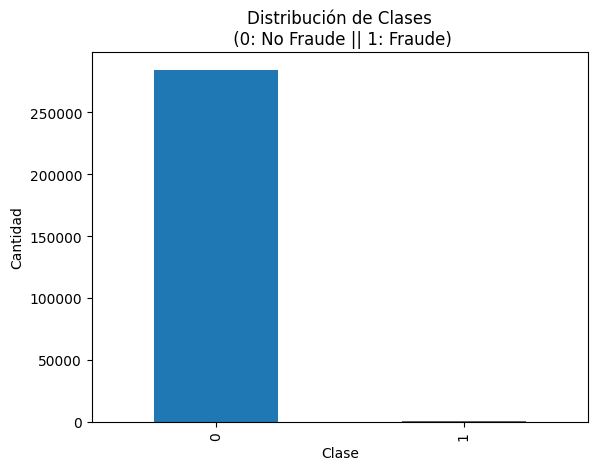


El dataset está muy desbalanceado: solo un 0.1727% de las transacciones son fraudulentas.


In [12]:
# Mostrar las primeras filas y la información general
print("\n--- Información del DataFrame ---")
df.info()

# --- Visualización del desbalance de clases ---
print("\n--- Distribución de Clases (Fraude vs. No Fraude) ---")
class_counts = df['Class'].value_counts()
print(class_counts)

# Gráfico para visualizar el desbalance
df['Class'].value_counts().plot(kind='bar')
plt.title('Distribución de Clases\n (0: No Fraude || 1: Fraude)')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()

# Imprimir el porcentaje de fraudes
fraud_percentage = (class_counts[1] / class_counts.sum()) * 100
print(f"\nEl dataset está muy desbalanceado: solo un {fraud_percentage:.4f}% de las transacciones son fraudulentas.")

### 1.3. Preparación de los datos

Antes de entrar a trabajar con los datos, hablemos antes sobre el preprocesamiento de datos tabulares (tablas) en Deep Learning. Esto es algo crítico y que tendrá un gran efecto sobre el entrenamiento de redes neuronales, y es que es esencial preparar los datos con dos transformaciones principales según el tipo de columna (variable):
1. **Codificación de variables categóricas (One-Hot Encoding)**: convierte una variables categórica (por ejemplo, color) en un formato numérico que el modelo pueda entender, creando una nueva variable *dummy* binaria (0 o 1) para cada categoría (por ejemplo, rojo, azul y verde). Por ejemplo, rojo se convierte en un vector [1, 0, 0], azul [0, 1, 0] y verde [0, 0, 1]. Esto evita que el modelo interprete las categorías como si tuvieran un orden o valor numérico, siendo "equidistantes" entre sí.

2. **Escalado de variables numéricas**: asegura que las variables con diferentes rangos y varianzas no dominen el entrenamiento. Esto previene que el modelo se vea sesgado por valores muy grandes o pequeños, mejorando su convergencia y rendimiento (por ejemplo, si en datos de viviendas, tenemos una variable con el tamaño en metros cuadrados y otra con el precio en euros). Hay dos métodos principales:  
  * **Normalización Min-Max (MinMaxScaler)**: Escala los datos para que se encuentren en un rango específico, generalmente [0, 1]. Útil cuando no conocemos la distribución de los datos, por ejemplo, en los valores de los píxeles de una imagen.
  * **Estandarización Z-Score (StandardScaler)**: Centra los datos a una media de 0 y una desviación estándar de 1. Es útil en algoritmos basados en gradiente o en reducción de dimensionalidad.

En nuestro caso, para proteger la privacidad de los usuarios y por cuestiones de confidencialidad, los creadores del dataset aplicaron una transformación matemática llamada *Análisis de Componentes Principales (PCA)* a los datos originales. Uno de los pasos estándar que se realizan antes de aplicar PCA es escalar los datos (por ejemplo, usando StandardScaler). Por lo tanto, las columnas `V` que recibimos en el dataset ya han sido transformadas y se encuentran en una escala comparable, centradas alrededor de cero. Puedes observar a continuación que las medias de estas variables son valores muy pequeños, cercanos al cero.

In [13]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Sin embargo, las columnas `Amount` y `Time` son las originales, sin haber sido procesadas con PCA. Sus valores numéricos son tan grandes que dominarían el proceso de aprendizaje de la red neuronal. El modelo le daría muchísima más importancia a una variación en Amount (que puede ser de miles) que a una variación en V1 (que puede ser de 0.1), simplemente por la diferencia de magnitud. 

A continuación haremos uso de `StandardScaler`, una funcionalidad de `sklearn` (si no la tienes instalada, te aconsejo instalarla con `pip install scikit-learn`) en `Time` y `Amount`, las ponemos en la misma "escala" que las variables V. Esto asegura que el modelo pueda aprender de todas las características de manera justa, sin que ninguna domine a las demás por su magnitud numérica.

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_Amount,scaled_Time
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,2.848070e+05,2.848070e+05
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727,2.913952e-17,-3.065637e-16
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,1.000002e+00,1.000002e+00
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,-3.532294e-01,-1.996583e+00
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,-3.308401e-01,-8.552120e-01
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000,-2.652715e-01,-2.131453e-01
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000,-4.471707e-02,9.372174e-01
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000,1.023622e+02,1.642058e+00


Las transacciones fraudulentas no tienden a suponer una gran cantidad de dinero (`Amount`), como se observa a continuación (observa la media y el máximo, y compáralo con la clase negativa):

In [25]:
print("--- Estadísticas de transacciones negativas (no fraufulentas) ---")
print(df[df["Class"] == 0]["Amount"].describe())
print("\n--- Estadísticas de transacciones positivas (fraudulentas) ---")
print(df[df["Class"] == 1]["Amount"].describe())

--- Estadísticas de transacciones negativas (no fraufulentas) ---
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

--- Estadísticas de transacciones positivas (fraudulentas) ---
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


Ahora preparamos las características X y la etiqueta objetivo Y, y partimos el dataset en dos de forma estratificada. Esto es, ya que tenemos una gran desbalance, obligar a que tengamos una proporción igual de 0's y 1's tanto en train como en test (si no, tendremos una gran probabilidad de tener en train solo ejemplos etiquetados como 0's).

In [ ]:
from sklearn.model_selection import train_test_split

# Eliminamos las columnas originales de 'Time' y 'Amount'
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Separamos características (X) y la etiqueta (y) 
X = df.drop('Class', axis=1)
y = df['Class']

# --- División Train-Test con ESTRATIFICACIÓN ---
# Usamos stratify=y para asegurar que la proporción de clases se mantenga en ambos conjuntos.
# Esto es fundamental en datasets desbalanceados.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Forma de X_train: ", X_train.shape)
print("Forma de X_test: ", X_test.shape)

print("\nDistribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nDistribución de clases en el conjunto de prueba:")
print(y_test.value_counts(normalize=True))

Forma de X_train: (227845, 30)
Forma de X_test: (56962, 30)

Distribución de clases en el conjunto de entrenamiento:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

Distribución de clases en el conjunto de prueba:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


In [ ]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)
train_ds = TensorDataset(X_train, y_train)

## 1. El Dataset IMDB

### 1.1. Descarga del dataset

Usaremos uno de los datasets que proporciona el sitio [IMDB](https://www.imdb.com) (Internet Movie DataBase) formado por 50.000 opiniones altamente polarizadas (lo que simplifica la tarea de aprendizaje). Este conjunto está dividido en 50%/50% para entrenamiento/test, y en cada uno de ellos hay un 50% de opiniones de cada tipo.

AL igual que con el dataset anterior (MNIST) este dataset también viene con Keras, y además se proporciona preprocesado: por medio de un diccionario indexado, las opiniones (secuencias de palabras) se han convertido en secuencias de enteros.

El código que carga el dataset (unos 80Mb de datos que serán descargados la primera vez que se ejecuta) es:

In [2]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


Como el diccionario es tremendamente grande y hay muchas palabras que se usan rara vez, nos quedaremos solo con las 10.000 palabras más frecuentes (algo que conseguimos por medio del argumento `num_words = 10000` en el proceso de carga). 

Si quieres, puedes explorar el contenido de las variables `train_data` y `test_data`, que son listas de opiniones, donde cada opinión es una lista de enteros (codificando una secuencia de palabras). Las variables `train_labels` y `test_labels` son listas binarias, donde 0 indica que la opinión asociada es _negativa_ y 1 que es _positiva_:

In [3]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
train_labels[0]

1

Puedes observar que los índices de las palabras almacenadas están por debajo de 10.000:

In [5]:
max([max(sequence) for sequence in train_data])

9999

Aunque no es necesario para el entrenamiento posterior, podemos construir funciones que reconstruyen las opiniones a partir de las secuencias de índices:

In [6]:
# word_index es un diccionario que mapea las palabras a un índice entero, lo podemos descargar:
word_index = imdb.get_word_index()
# Lo invertimos, mapeando índices enteros a palabras
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Decodificamos la review; observa que nuestros índices tiene un offset de 3
# porque 0, 1 y 2 están reservados para los índices de "padding", "start of sequence", y "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [7]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### 1.2. Preparación de los datos

Como las redes neuronales no admiten listas de enteros como entrada porque son estructuras de datos de longitud variable, hemos de añadir un preprocesado adicional para poder trabajar con ellas. Tenemos dos opciones:

* Completar las listas más cortas para que todas tengan la misma longitud y, entonces, convertirlas en tensores que alimentarán la capa de entrada de la red.
* Codificar en One-hot las listas para convertirlas en vectores de 0s y 1s. Como tenemos un máximo de 10.000 palabras en nuestro vocabulario, cada opinión se convertirá en una lista binaria de 10.000 posiciones indicando qué palabras aparecen en la opinión. En este caso, la primera capa (densa) de nuestra red se conectaría con vectores de longitud 10.000.

Optaremos por esta segunda opción, que más adelante veremos que tiene más ventajas que la primera. 

El código que permite hacer esta conversión es:

In [8]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Crea una matriz con todo 0 con shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # Asigna los índices específicos para results[i] con 1s
    return results

# Vectorizamos training data
x_train = vectorize_sequences(train_data)
# Vectorizamos test data
x_test = vectorize_sequences(test_data)

Este es el nuevo aspecto que tendría una opinión:

In [9]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

También tendríamos que hacer una conversión con las etiquetas, pero como en este caso ya son vectores binarios, basta convertirlos en numéricos:

In [10]:
# Vectorizamos las labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## 2. Definiendo la Red

Como hemos visto, los datos de entrada son vectores, y las etiquetas son escalares (1s y 0s), así que estamos ante la configuración más sencilla de las posibles para ser trabajadas con una red neuronal, y un tipo de red que funciona bien con este tipo de problemas es una simple pila de capas densas con activaciones `relu`, que en Keras se construyen con la instrucción: `layers.Dense(16, activation='relu')`.

En general, en todo tipo de capas, los argumentos más habituales que tendrás que usar serán el número de neuronas en la capa, y el tipo de activación que usarán estas neuronas. En el caso anterior usamos 16 neuronas, lo que significa que esta capa usará 16 dimensiones para intentar estructurar los patrones que encuentre en los datos de entrada según la función objetivo (loss) que deba optimizar. 

Se puede interpretar intuitivamente que la dimensión de la capa representa cuánta libertad se permite a la red para aprender representaciones internas. Tener más unidades permite aprender representaciones más complejas, pero también aumenta la carga computacional y facilita la memorización de patrones en los datos de entrenamiento (que quizás no sean relevantes para el problema y que puede llevar a un fenómeno de sobreajuste).

Respecto a la arquitectura al trabajar con capas densas, hay dos decisiones claves que considerar:

* Cuántas capas usar.
* Cuántas unidades colocar en cada capa.

Aunque no hay reglas generales para saber cómo tomar estas decisiones, sí que hay algunas razones que se pueden aprender con la experiencia y así poder extraer algún conocimiento implícito útil para el diseño de redes. Para este ejemplo, sin una justificación clara, y solo a modo de demostración de las técnicas vamos a usar dos capas intermedias de 16 neuronas cada una, y una tercera capa que tendrá una única salida escalar (que representará la predicción del modelo). Las capas intermedias usarán `relu` como función de activación, y la capa final usará una sigmoide (que tiene una salida en $[0, 1]$).

La implementación en Keras, similar a la que ya hicimos para MNIST, es por tanto:

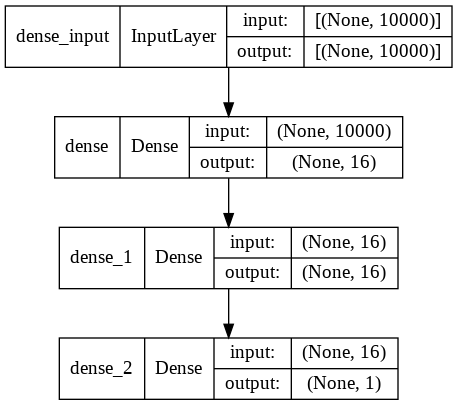

In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

red = models.Sequential()
red.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
red.add(layers.Dense(16, activation='relu'))
red.add(layers.Dense(1, activation='sigmoid'))
plot_model(red, to_file='IMDBModel_plot.png', show_shapes=True, show_layer_names=True)

Si aún no tienes configurada la función para plots, a continuación se muestra la salida esperada:

![](https://github.com/miguelamda/DL/blob/master/3.%20Frameworks%20Software/imgs/IMDBModel_plot.png?raw=1)

Siguiendo el mismo patrón que vimos en el ejemplo anterior, necesitamos elegir la función de pérdida (que será minimizada) y el método de optimización (que será el que busque minimizar esa función). 

Como estamos ante un problema de clasificación binaria y la salida de nuestra red es una probabilidad (proporcionada por la sigmoide), usaremos `binary_crossentropy` como función de pérdida. No es la única opción viable, podríamos haber elegido, por ejemplo, `mean_squared_error`, pero en este caso `binary_crossentropy` es la mejor opción por estar trabajando con probabilidades. La entropía cruzada proviene del campo de **Teoría de la Información**, y mide la distancia entre distribuciones de probabilidad (en este caso, la distribución calculada por el predictor y la que representa la distribución _real_ proveniente de los datos de entrenamiento).

Como optimizador usaremos `rmsprop`, que suele ser una buena elección. Para monitorear la evolución del aprendizaje usaremos una sola métrica, _accuracy_.

In [12]:
red.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

En este caso estamos pasando todos los datos como cadenas que vienen predefinidas en Keras y trabajan con parámetros fijos, pero también es posible ajustar con más flexibilidad cada una de ellas y configurar los parámetros de los que depende, e incluso pasarle funciones, ya sean las que trae Keras o completamente personalizadas. De esta manera ahora por ejemplo podemos ajustar el **learning rate**. Por ejemplo:

In [13]:
from tensorflow.keras import optimizers

red.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


O incluso de forma más detallada como:

In [14]:
from tensorflow.keras import losses
from tensorflow.keras import metrics

red.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## 3. Validando el modelo

Con el fin de monitorizar la métrica (_accuracy_) mientras se produce el entrenamiento necesitamos tener más datos que el modelo no use durante el proceso. Crearemos para ello un *conjunto de validación* separando otras 10.000 muestras del conjunto original. Así pues la situación queda como:

* _Conjunto de entrenamiento_: con el que intentaremos optimizar los pesos de la red para que minimice la función de pérdida. En este proceso se usa un modelo que depende de ciertos parámetros que quizás deban ser ajustados para conseguir mejorar el rendimiento.

* _Conjunto de validación_: con el que se medirá cómo de bueno es el modelo concreto que estamos entrenando (con unos parámetros fijos). Es algo así como un conjunto de test temporal. Permite ajustar estos parámetros para mejorar el rendimiento.

* _Conjunto de test_: que no se ha usado en ningún momento de las iteraciones anteriores y que permite medir de forma objetiva la bondad del modelo final obtenido.

In [15]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

A continuación, entrenaremos el modelo realizando 20 iteraciones (_epochs_) sobre el conjunto completo de entrenamiento, ni validación, ni test), en mini-batches de 512 muestras (es decir, cada 512 muestras analizadas, se actualizan los pesos de la red). Monitorearemos _loss_ y _accuracy_ sobre las 10.000 muestras que dejamos en el conjunto de validación. Para ello, usamos el argumento `validation_data` de la función `fit`, que no usamos en el ejemplo anterior:

In [16]:
entrenamiento = red.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 4s 72ms/step - loss: 0.5678 - binary_accuracy: 0.7735 - val_loss: 0.4510 - val_binary_accuracy: 0.8649
Epoch 2/20
30/30 [==============================] - 1s 50ms/step - loss: 0.3625 - binary_accuracy: 0.8938 - val_loss: 0.3475 - val_binary_accuracy: 0.8700
Epoch 3/20
30/30 [==============================] - 2s 52ms/step - loss: 0.2578 - binary_accuracy: 0.9184 - val_loss: 0.3096 - val_binary_accuracy: 0.8776
Epoch 4/20
30/30 [==============================] - 2s 57ms/step - loss: 0.1987 - binary_accuracy: 0.9362 - val_loss: 0.2765 - val_binary_accuracy: 0.8894
Epoch 5/20
30/30 [==============================] - 2s 61ms/step - loss: 0.1606 - binary_accuracy: 0.9483 - val_loss: 0.2835 - val_binary_accuracy: 0.8869
Epoch 6/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1301 - binary_accuracy: 0.9590 - val_loss: 0.2954 - val_binary_accuracy: 0.8828
Epoch 7/20
30/30 [==============================] - 1s 35ms/step - los

Aunque no lo usamos en el ejemplo anterior, y tampoco pasamos el resultado a una variable para poder hacerlo, la llamada a `fit()` devuelve un objeto `history`, que tiene la siguiente estructura:


In [17]:
entrenamiento_dict = entrenamiento.history
entrenamiento_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

En este caso, este objeto contiene 4 entradas, una por cada métrica que está siendo monitorizada durante el entrenamiento y durante la validación. Podemos usar `Matplotlib` para representar las pérdidas/precisión de entrenamiento y validación simultáneamente:

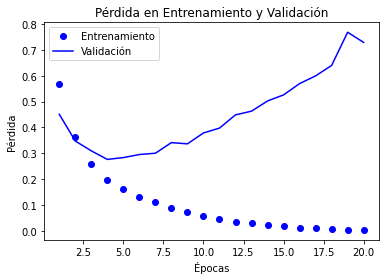

In [19]:
import matplotlib.pyplot as plt

# extraemos los valores de la función de pérdida sobre entrenamiento y validación
ent_loss = entrenamiento.history['loss']
val_loss = entrenamiento.history['val_loss']

epochs = range(1, len(ent_loss) + 1)

# "bo" es para "blue dot" (punto azul)
plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
# b es para "solid blue line" (línea azul sólida)
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

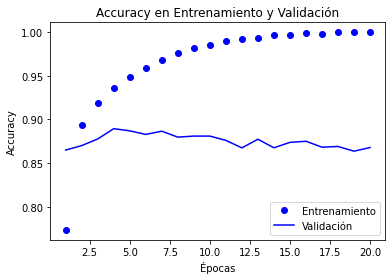

In [20]:
plt.clf()   # Limpiamos la figura
# extraemos el rendimiento obtenido con entrenamiento según la métrica escogida, binary_accuracy
ent_acc = entrenamiento.history['binary_accuracy']
# extraemos el rendimiento obtenido con validación según la métrica escogida, binary_accuracy
val_acc = entrenamiento.history['val_binary_accuracy']

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Estas gráficas muestras que la _pérdida_ de entrenamiento decrece en cada epoch, y que el _accuracy_ en entrenamiento crece, algo que indica que el procedimiento de optimización está funcionando adecuadamente (sobre todo respecto a la función de pérdida). Pero en este caso observamos que no ocurre lo mismo con la validación, que empiezan a empeorar a partir de la época 4. Estamos ante un claro caso de *sobreajuste* (u *overfitting*): tras unos pocos pasos el sistema se sobreajusta a los datos de entrenamiento, y aprende una representación que es específica a estos datos y que no puede generalizarse a otros datos.

En este caso, para prevenir el overfitting podríamos parar el entrenamiento tras las 3 primeras iteraciones. Más adelante veremos algunas otras técnicas para mitigar este efecto, pero por ahora nos contentaremos con este procedimiento que, aún lejos de ser el mejor, evita este problema ahora mismo.

Vamos a entrenar una nueva red desde el principio pero solo durante 4 epochs y después evaluaremos el modelo sobre los datos de test (observa que estos datos no los hemos usado en ningún momento hasta ahora):

In [21]:
# para entrenar de nuevo volvemos a crear el modelo
red2 = models.Sequential()
red2.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
red2.add(layers.Dense(16, activation='relu'))
red2.add(layers.Dense(1, activation='sigmoid'))

red2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

red2.fit(x_train, y_train, epochs=4, batch_size=512)
results = red2.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 26ms/step - loss: 0.4903 - accuracy: 0.8119
Epoch 2/4
49/49 [==============================] - 1s 27ms/step - loss: 0.2784 - accuracy: 0.9060
Epoch 3/4
49/49 [==============================] - 1s 26ms/step - loss: 0.2061 - accuracy: 0.9270
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2924 - accuracy: 0.8850


In [22]:
results

[0.29238229990005493, 0.8850399851799011]

Vemos que la aproximación tan simple que hemos hecho consigue un accuracy del 88% (el estado del arte actual para este problema ronda del 95%, pero trabajando sobre redes mucho más elaboradas).

## 4. Predicciones sobre datos nuevos

Tras haber entrenado la red, el paso natural es usar el modelo para algo práctico. Puedes generar nuevas predicciones sobre opiniones para analizar si son positivas o no usando  el método `predict` asociado al modelo:

In [23]:
red2.predict(x_test)

array([[0.21402693],
       [0.9999603 ],
       [0.9390079 ],
       ...,
       [0.09875163],
       [0.07413131],
       [0.58967245]], dtype=float32)

Verás que el modelo es muy determinante en algunos casos (alcanzando valores como 0,99 o 0,01) pero no tanto en otros (como 0,46).

## 5. Trabajo Opcional Propuesto

* En los modelos anteriores hemos usado 2 capas ocultas... comprueba el efecto de ampliar o reducir este número sobre la accuracy de validación y de test.
* Cambia el número de unidades en las capas ocultas (8, 32, 64,...) y mide su efecto.
* Mira qué ocurre al usar `mse` como función de pérdida, en vez de `binary_crossentropy`.
* Mira qué ocurre al usar la activación `tanh` en vez de `relu`.

## 6. Conclusiones

A pesar de haber analizado únicamente un ejemplo de introducción sin llegar a profundizar en detalles ni experimentar profundamente con los parámetros, podemos ir ya apuntando algunas conclusiones importantes que pueden ayudarnos en casos posteriores:

* El trabajo de preprocesamiento sobre los datos es una etapa esencial para que puedas alimentar a las redes (no olvides que se alimentan de tensores).
* Las secuencias de palabras se pueden codificar como vectores binarios, aunque hay otras opciones.
* Las pilas de capas densas con activaciones `relu` pueden resolver una amplia variedad de problemas... así que no las olvides.
* En los problemas de clasificación binaria, la red debería acabar en una capa densa con una sola neurona que haga uso de la activación `sigmoid`. De esta forma, la salida será un único escalar en $[0,1]$ que se puede interpretar como una probabilidad.
* En este caso (salida sigmoide en un problema de clasificación binario) una función de pérdida adecuada es `binary_crossentropy`.
* El optimizador `rmsprop` es normalmente una buena opción.
* Cuidado con el *overfitting*. Asegúrate de monitorear la evolución del entrenamiento (acuérdate de preparar un conjunto de validación adicional).

* [Credit card fraud detection with Pytorch](https://blacksuan19.dev/projects/credit-card-fraud-detection-with-pytorch/)
* [Cienciadedatos.net](https://cienciadedatos.net/documentos/py35-redes-neuronales-python.html)